In [ ]:
!pip install catboost
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor
sns.set(style="darkgrid")


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
items=pd.read_csv("/content/drive/My Drive/Kaggle Data/items.csv")
shops=pd.read_csv("/content/drive/My Drive/Kaggle Data/shops.csv")
cats=pd.read_csv("/content/drive/My Drive/Kaggle Data/item_categories.csv")
train=pd.read_csv("/content/drive/My Drive/Kaggle Data/sales_train.csv")
test=pd.read_csv("/content/drive/My Drive/Kaggle Data/test.csv")

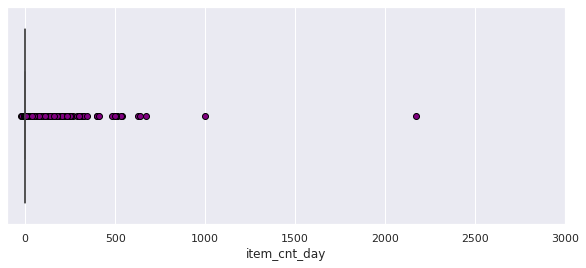

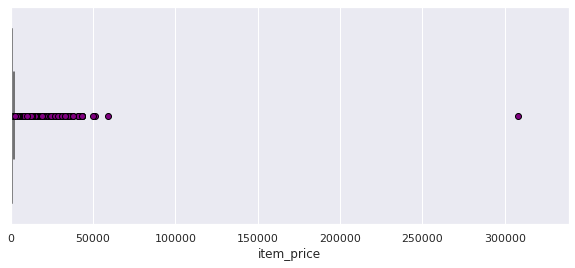

In [ ]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=train.item_cnt_day, flierprops=flierprops)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price, flierprops=flierprops)

In [ ]:
train = train[(train.item_price < 300000 )& (train.item_cnt_day < 1000)]

In [ ]:
train = train[train.item_price > 0].reset_index(drop = True)
train.loc[train.item_cnt_day < 1, "item_cnt_day"] = 0

In [ ]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [ ]:
shops.loc[ shops.shop_name == 'Сергиев Посад ТЦ "7Я"',"shop_name" ] = 'СергиевПосад ТЦ "7Я"'
shops["city"] = shops.shop_name.str.split(" ").map( lambda x: x[0] )
shops["category"] = shops.shop_name.str.split(" ").map( lambda x: x[1] )
shops.loc[shops.city == "!Якутск", "city"] = "Якутск"

In [ ]:
category = []
for cat in shops.category.unique():
    if len(shops[shops.category == cat]) >= 5:
        category.append(cat)
shops.category = shops.category.apply( lambda x: x if (x in category) else "other" )

In [ ]:
from sklearn.preprocessing import LabelEncoder
shops["shop_category"] = LabelEncoder().fit_transform( shops.category )
shops["shop_city"] = LabelEncoder().fit_transform( shops.city )
shops = shops[["shop_id", "shop_category", "shop_city"]]

In [ ]:
cats["type_code"] = cats.item_category_name.apply( lambda x: x.split(" ")[0] ).astype(str)
cats.loc[ (cats.type_code == "Игровые")| (cats.type_code == "Аксессуары"), "category" ] = "Игры"

In [ ]:
category = []
for cat in cats.type_code.unique():
    if len(cats[cats.type_code == cat]) >= 5: 
        category.append( cat )
cats.type_code = cats.type_code.apply(lambda x: x if (x in category) else "etc")

In [ ]:
cats.type_code = LabelEncoder().fit_transform(cats.type_code)
cats["split"] = cats.item_category_name.apply(lambda x: x.split("-"))
cats["subtype"] = cats.split.apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats["subtype_code"] = LabelEncoder().fit_transform( cats["subtype"] )
cats = cats[["item_category_id", "subtype_code", "type_code"]]

In [ ]:
import re
def name_correction(x):
    x = x.lower() # all letters lower case
    x = x.partition('[')[0] # partition by square brackets
    x = x.partition('(')[0] # partition by curly brackets
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x) # remove special characters
    x = x.replace('  ', ' ') # replace double spaces with single spaces
    x = x.strip() # remove leading and trailing white space
    return x

In [ ]:
# split item names by first bracket
items["name1"], items["name2"] = items.item_name.str.split("[", 1).str
items["name1"], items["name3"] = items.item_name.str.split("(", 1).str

# replace special characters and turn to lower case
items["name2"] = items.name2.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()
items["name3"] = items.name3.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()

# fill nulls with '0'
items = items.fillna('0')

items["item_name"] = items["item_name"].apply(lambda x: name_correction(x))

# return all characters except the last if name 2 is not "0" - the closing bracket
items.name2 = items.name2.apply( lambda x: x[:-1] if x !="0" else "0")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
items["type"] = items.name2.apply(lambda x: x[0:8] if x.split(" ")[0] == "xbox" else x.split(" ")[0] )
items.loc[(items.type == "x360") | (items.type == "xbox360") | (items.type == "xbox 360") ,"type"] = "xbox 360"
items.loc[ items.type == "", "type"] = "mac"
items.type = items.type.apply( lambda x: x.replace(" ", "") )
items.loc[ (items.type == 'pc' )| (items.type == 'pс') | (items.type == "pc"), "type" ] = "pc"
items.loc[ items.type == 'рs3' , "type"] = "ps3"

In [ ]:
group_sum = items.groupby(["type"]).agg({"item_id": "count"})
group_sum = group_sum.reset_index()
drop_cols = []
for cat in group_sum.type.unique():
    if group_sum.loc[(group_sum.type == cat), "item_id"].values[0] <40:
        drop_cols.append(cat)
items.name2 = items.name2.apply( lambda x: "other" if (x in drop_cols) else x )
items = items.drop(["type"], axis = 1)

In [ ]:
items.name2 = LabelEncoder().fit_transform(items.name2)
items.name3 = LabelEncoder().fit_transform(items.name3)

items.drop(["item_name", "name1"],axis = 1, inplace= True)
items.head()

,item_id,item_category_id,name2,name3
0,0,40,4,1331
1,1,76,64,42
2,2,40,4,1011
3,3,40,4,1010
4,4,40,4,1572


In [ ]:
from itertools import product
import time
ts = time.time()
matrix = []
cols  = ["date_block_num", "shop_id", "item_id"]
for i in range(34):
    sales = train[train.date_block_num == i]
    matrix.append( np.array(list( product( [i], sales.shop_id.unique(), sales.item_id.unique() ) ), dtype = np.int16) )

matrix = pd.DataFrame( np.vstack(matrix), columns = cols )
matrix["date_block_num"] = matrix["date_block_num"].astype(np.int8)
matrix["shop_id"] = matrix["shop_id"].astype(np.int8)
matrix["item_id"] = matrix["item_id"].astype(np.int16)
matrix.sort_values( cols, inplace = True )
time.time()- ts

11.851993083953857

In [ ]:
# add revenue to train df
train["revenue"] = train["item_cnt_day"] * train["item_price"]

In [ ]:
ts = time.time()
group = train.groupby( ["date_block_num", "shop_id", "item_id"] ).agg( {"item_cnt_day": ["sum"]} )
group.columns = ["item_cnt_month"]
group.reset_index( inplace = True)
matrix = pd.merge( matrix, group, on = cols, how = "left" )
matrix["item_cnt_month"] = matrix["item_cnt_month"].fillna(0).astype(np.float16)
time.time() - ts

4.994715929031372

In [ ]:
test["date_block_num"] = 34
test["date_block_num"] = test["date_block_num"].astype(np.int8)
test["shop_id"] = test.shop_id.astype(np.int8)
test["item_id"] = test.item_id.astype(np.int16)

In [ ]:
ts = time.time()

matrix = pd.concat([matrix, test.drop(["ID"],axis = 1)], ignore_index=True, sort=False, keys=cols)
matrix.fillna( 0, inplace = True )
time.time() - ts

0.09147119522094727

In [ ]:
ts = time.time()
matrix = pd.merge( matrix, shops, on = ["shop_id"], how = "left" )
matrix = pd.merge(matrix, items, on = ["item_id"], how = "left")
matrix = pd.merge( matrix, cats, on = ["item_category_id"], how = "left" )
matrix["shop_city"] = matrix["shop_city"].astype(np.int8)
matrix["shop_category"] = matrix["shop_category"].astype(np.int8)
matrix["item_category_id"] = matrix["item_category_id"].astype(np.int8)
matrix["subtype_code"] = matrix["subtype_code"].astype(np.int8)
matrix["name2"] = matrix["name2"].astype(np.int8)
matrix["name3"] = matrix["name3"].astype(np.int16)
matrix["type_code"] = matrix["type_code"].astype(np.int8)
time.time() - ts

3.864502429962158

In [ ]:
# Define a lag feature function
def lag_feature( df,lags, cols ):
    for col in cols:
        print(col)
        tmp = df[["date_block_num", "shop_id","item_id",col ]]
        for i in lags:
            shifted = tmp.copy()
            shifted.columns = ["date_block_num", "shop_id", "item_id", col + "_lag_"+str(i)]
            shifted.date_block_num = shifted.date_block_num + i
            df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [ ]:
ts = time.time()
matrix = lag_feature( matrix, [1,2,3], ["item_cnt_month"] )
time.time() - ts

item_cnt_month


22.262478590011597

In [ ]:
ts = time.time()
group = matrix.groupby( ["date_block_num"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num"], how = "left")
matrix.date_avg_item_cnt = matrix["date_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1], ["date_avg_item_cnt"] )
matrix.drop( ["date_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

date_avg_item_cnt


11.455872297286987

In [ ]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix.date_item_avg_item_cnt = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3], ['date_item_avg_item_cnt'])
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_item_avg_item_cnt


27.103676795959473

In [ ]:
ts = time.time()
group = matrix.groupby( ["date_block_num","shop_id"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_shop_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num","shop_id"], how = "left")
matrix.date_avg_item_cnt = matrix["date_shop_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1,2,3], ["date_shop_avg_item_cnt"] )
matrix.drop( ["date_shop_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys


date_shop_avg_item_cnt


27.959697246551514

In [ ]:
ts = time.time()
group = matrix.groupby( ["date_block_num","shop_id","item_id"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_shop_item_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num","shop_id","item_id"], how = "left")
matrix.date_avg_item_cnt = matrix["date_shop_item_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1,2,3], ["date_shop_item_avg_item_cnt"] )
matrix.drop( ["date_shop_item_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys


date_shop_item_avg_item_cnt


41.370965003967285

In [ ]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix.date_shop_subtype_avg_item_cnt = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_shop_subtype_avg_item_cnt'])
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_shop_subtype_avg_item_cnt


15.021512031555176

In [ ]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_city']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_city_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', "shop_city"], how='left')
matrix.date_city_avg_item_cnt = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_city_avg_item_cnt'])
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_city_avg_item_cnt


14.846555233001709

In [ ]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'shop_city']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'shop_city'], how='left')
matrix.date_item_city_avg_item_cnt = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_item_city_avg_item_cnt'])
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_item_city_avg_item_cnt


23.393680572509766

In [ ]:
ts = time.time()
group = train.groupby( ["item_id"] ).agg({"item_price": ["mean"]})
group.columns = ["item_avg_item_price"]
group.reset_index(inplace = True)

matrix = matrix.merge( group, on = ["item_id"], how = "left" )
matrix["item_avg_item_price"] = matrix.item_avg_item_price.astype(np.float16)


group = train.groupby( ["date_block_num","item_id"] ).agg( {"item_price": ["mean"]} )
group.columns = ["date_item_avg_item_price"]
group.reset_index(inplace = True)

matrix = matrix.merge(group, on = ["date_block_num","item_id"], how = "left")
matrix["date_item_avg_item_price"] = matrix.date_item_avg_item_price.astype(np.float16)
lags = [1, 2, 3]
matrix = lag_feature( matrix, lags, ["date_item_avg_item_price"] )
for i in lags:
    matrix["delta_price_lag_" + str(i) ] = (matrix["date_item_avg_item_price_lag_" + str(i)]- matrix["item_avg_item_price"] )/ matrix["item_avg_item_price"]

def select_trends(row) :
    for i in lags:
        if row["delta_price_lag_" + str(i)]:
            return row["delta_price_lag_" + str(i)]
    return 0


matrix["delta_price_lag"] = matrix.apply(select_trends, axis = 1)
matrix["delta_price_lag"] = matrix.delta_price_lag.astype( np.float16 )
matrix["delta_price_lag"].fillna( 0 ,inplace = True)

features_to_drop = ["item_avg_item_price", "date_item_avg_item_price"]
for i in lags:
    features_to_drop.append("date_item_avg_item_price_lag_" + str(i) )
    features_to_drop.append("delta_price_lag_" + str(i) )
matrix.drop(features_to_drop, axis = 1, inplace = True)
time.time() - ts

date_item_avg_item_price


309.12245202064514

In [ ]:
ts = time.time()
group = train.groupby( ["date_block_num","shop_id"] ).agg({"revenue": ["sum"] })
group.columns = ["date_shop_revenue"]
group.reset_index(inplace = True)

matrix = matrix.merge( group , on = ["date_block_num", "shop_id"], how = "left" )
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(["shop_id"]).agg({ "date_block_num":["mean"] })
group.columns = ["shop_avg_revenue"]
group.reset_index(inplace = True )

matrix = matrix.merge( group, on = ["shop_id"], how = "left" )
matrix["shop_avg_revenue"] = matrix.shop_avg_revenue.astype(np.float32)
matrix["delta_revenue"] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix["delta_revenue"] = matrix["delta_revenue"]. astype(np.float32)

matrix = lag_feature(matrix, [1], ["delta_revenue"])
matrix["delta_revenue_lag_1"] = matrix["delta_revenue_lag_1"].astype(np.float32)
matrix.drop( ["date_shop_revenue", "shop_avg_revenue", "delta_revenue"] ,axis = 1, inplace = True)
time.time() - ts

delta_revenue


15.983875751495361

In [ ]:
matrix["month"] = matrix["date_block_num"] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix["days"] = matrix["month"].map(days).astype(np.int8)

In [ ]:
ts = time.time()
matrix["item_shop_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_id","shop_id"])["date_block_num"].transform('min')
matrix["item_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_id"])["date_block_num"].transform('min')
time.time() - ts

1.988295078277588

In [ ]:
ts = time.time()
matrix = matrix[matrix["date_block_num"] > 3]
time.time() - ts

1.058492660522461

In [ ]:
import gc
import pickle
from xgboost import XGBRegressor
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [ ]:
data = matrix.copy()
del matrix
gc.collect()

12

In [ ]:
data[data["date_block_num"]==34].shape

(214200, 33)

In [ ]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [ ]:
Y_train = Y_train.clip(0, 20)
Y_valid = Y_valid.clip(0, 20)

In [ ]:
del data
gc.collect();

In [ ]:
X_train

,date_block_num,shop_id,item_id,shop_category,shop_city,item_category_id,name2,name3,subtype_code,type_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_item_avg_item_cnt_lag_1,date_shop_item_avg_item_cnt_lag_2,date_shop_item_avg_item_cnt_lag_3,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,days,item_shop_first_sale,item_first_sale
1497465,4,2,27,4,0,19,76,42,10,3,0.0,0.0,0.0,0.286865,0.021744,0.086975,0.065247,0.071838,0.091064,0.059875,0.0,0.0,0.0,0.449463,0.071838,0.0,0.367676,37326.816406,4,31,4,4
1497466,4,2,28,4,0,30,107,42,55,3,0.0,0.0,0.0,0.286865,0.130493,0.152222,0.173950,0.071838,0.091064,0.059875,0.0,0.0,0.0,0.387207,0.071838,0.0,0.256348,37326.816406,4,31,4,4
1497467,4,2,29,4,0,23,123,42,16,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,4,31,4,4
1497468,4,2,30,4,0,40,4,42,4,5,0.0,1.0,0.0,0.286865,2.826172,11.046875,18.734375,0.071838,0.091064,0.059875,0.0,1.0,0.0,0.018585,0.071838,0.0,0.212402,37326.816406,4,31,3,3
1497469,4,2,31,4,0,37,4,562,1,5,1.0,1.0,4.0,0.286865,1.260742,4.781250,13.648438,0.071838,0.091064,0.059875,1.0,1.0,4.0,0.035919,0.071838,1.0,0.191040,37326.816406,4,31,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10675627,32,59,22162,4,30,40,4,42,4,5,1.0,0.0,0.0,0.308594,0.333252,0.627930,0.511719,0.238037,0.187500,0.175049,1.0,0.0,0.0,0.111633,0.238037,1.0,-0.085815,60673.121094,8,30,14,14
10675628,32,59,22163,4,30,40,4,36,4,5,0.0,NaN,NaN,0.308594,0.690430,NaN,NaN,0.238037,NaN,NaN,0.0,NaN,NaN,0.111633,0.238037,0.0,-0.008354,60673.121094,8,30,1,1
10675629,32,59,22164,4,30,37,4,562,1,5,0.0,1.0,0.0,0.308594,0.476074,0.279053,0.162842,0.238037,0.187500,0.175049,0.0,1.0,0.0,0.117859,0.238037,0.0,-0.114929,60673.121094,8,30,7,7
10675630,32,59,22166,4,30,54,-85,42,61,6,0.0,0.0,0.0,0.308594,0.261963,0.186035,0.232544,0.238037,0.187500,0.175049,0.0,0.0,0.0,0.000000,0.238037,0.0,0.000000,60673.121094,8,30,23,23


In [ ]:
Y_train

1497465     0.0
1497466     0.0
1497467     0.0
1497468     0.0
1497469     0.0
           ... 
10675627    0.0
10675628    0.0
10675629    0.0
10675630    0.0
10675631    0.0
Name: item_cnt_month, Length: 9178167, dtype: float16

In [ ]:
catboost_model = CatBoostRegressor(
    iterations=500,
    max_ctr_complexity=4,
    random_seed=0,
    od_type='Iter',
    od_wait=25,
    verbose=50,
    depth=4
)

catboost_model.fit(
    X_train, Y_train
)

In [ ]:
from sklearn import *
from lightgbm import LGBMClassifier
import time
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [ ]:
lgb = LGBMClassifier(
    objective='binary',
    boosting='gbdt',
    learning_rate = 0.05,
    max_depth = 8,
    num_leaves = 80,
    n_estimators = 400,
    bagging_fraction = 0.8,
    feature_fraction = 0.9)
    #reg_alpha = 0.2,
    #reg_lambda = 0.4)

In [ ]:
t = time.time()
print('Fitting Up')
lgb.fit(X_train,Y_train)
print('Done')
print(f'Done, time = {time.time() - t}')

Fitting Up
Done
Done, time = 12683.025570631027


In [ ]:
ts = time.time()

model = XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,
#     tree_method='gpu_hist',
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 20)

time.time() - ts

[07:13:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:13:09] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.12359	validation_1-rmse:1.11776
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:1.08296	validation_1-rmse:1.07911
[2]	validation_0-rmse:1.04721	validation_1-rmse:1.04677
[3]	validation_0-rmse:1.01094	validation_1-rmse:1.01885
[4]	validation_0-rmse:0.984228	validation_1-rmse:0.997916
[5]	validation_0-rmse:0.96087	validation_1-rmse:0.980793
[6]	validation_0-rmse:0.939567	validation_1-rmse:0.965107
[7]	validation_0-rmse:0.920986	validation_1-rmse:0.954201
[8]	validation_0-rmse:0.905571	validation_1-r

5715.786360740662

In [ ]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)

In [ ]:
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))